## 1. Problem Definition

Goal: Predicting price of bulldozers using a regression machine-learning algorithm

## 2. Data

The data that we will use will be pulled from a Kaggle competition: https://www.kaggle.com/competitions/bluebook-for-bulldozers/data. 

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluaton

In order to be successful, the RMSLE (Root Mean Squared Log Error) between actual and predicted auction prices must be as low as possible.

## 4. Features

This project includes the features listed <a href="C:\Users\jtass\PycharmProjects\bulldozer-pricing\data\bluebook-for-bulldozers\Data Dictionary.xlsx">here</a>.

### Importing the tools

We will use a combination of Pandas, Numpy, Matplotlib, and scikit-learn.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

### Exploratory Data Analysis

In [2]:
# Import data sets
train_val_df = pd.read_csv("./data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False)
test_df = pd.read_csv("./data/bluebook-for-bulldozers/Test.csv")


In [3]:
# View the data (training)
train_val_df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Investigate data types (training)
train_val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

Key pieces of information to investigate:
* Model ID
* Year Made
* Date Sold
* Sale Price

In [5]:
# Investigate missing data (training)
train_val_df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

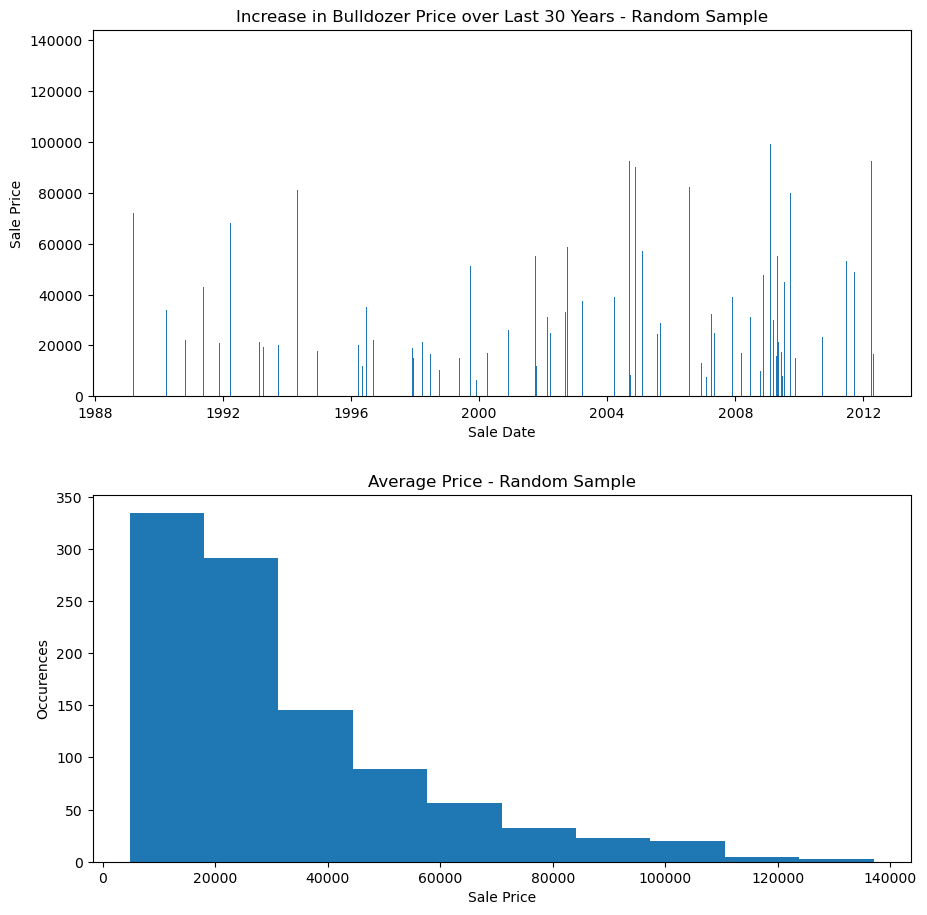

In [6]:
# Investigate Price vs Sale Date
train_val_df['saledate'] = pd.to_datetime(train_val_df["saledate"])

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
fig.tight_layout(pad=5.0)

np.random.seed(42)
random_sample = train_val_df.sample(1000)
sample_sale_date = random_sample["saledate"]
sample_sale_price = random_sample["SalePrice"]

ax1.bar(sample_sale_date, sample_sale_price)
ax1.set(title="Increase in Bulldozer Price over Last 30 Years - Random Sample", xlabel="Sale Date", ylabel="Sale Price");

ax2.hist(sample_sale_price)
ax2.set(title="Average Price - Random Sample", xlabel="Sale Price", ylabel="Occurences");

Key findings:

* Price has increased slightly over time
* Price is typically below ~35000

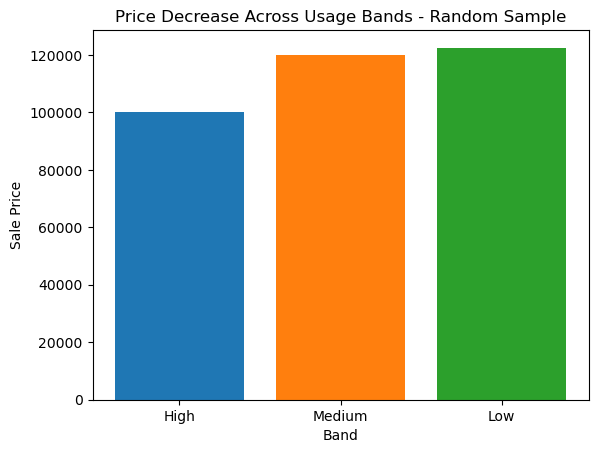

In [30]:
# Investigate Price to Usage Band

# Set random seed
np.random.seed(42)

# Clean usage band to be numeric for bar graph
random_sample = train_val_df.sample(1000)
nulls = pd.get_dummies(random_sample["UsageBand"])
merged_sample = pd.concat([nulls, random_sample], axis='columns')
merged_sample.drop(["UsageBand"], axis='columns')

# Set random subsets for band and price
sample_usage_band_high = merged_sample[merged_sample["High"] == 1]
sample_usage_band_med = merged_sample[merged_sample["Medium"] == 1]
sample_usage_band_low = merged_sample[merged_sample["Low"] == 1]

# Plot

fig, ax1 = plt.subplots()

# Define structure of graph
ax1.bar("High", sample_usage_band_high["SalePrice"], label="High")
ax1.bar("Medium", sample_usage_band_med["SalePrice"], label="Medium")
ax1.bar("Low", sample_usage_band_low["SalePrice"], label="Low")
ax1.set(title="Price Decrease Across Usage Bands - Random Sample", xlabel="Band", ylabel="Sale Price");

Findings:

* On average, low and medium usage have smaller price difference. High usage typically reduces price significantly.